## MAP535 Regression - Data Project: Abalone Set

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics as smg
from diagnostic_plots import *
from pingouin import ancova
sns.set_theme()
np.warnings.filterwarnings('ignore')

### **Part I: EDA and Model Validation**




In [2]:
def load_data():
    URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
    COL_NAMES = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
    return pd.read_csv(URL, sep=',', names=COL_NAMES)

In [3]:
df = load_data()
df = pd.get_dummies(df, columns=['Sex'])

In [4]:
np.random.seed(42)
indexes = np.random.choice(len(df), np.int(len(df) * 0.7),replace=False)
df_train = df.loc[indexes].reset_index(drop=True) # We reindex the dataframes in order to prevent errors laterfa
df_test = df.loc[~(df.index.isin(indexes))].reset_index(drop=True)

**Question 1.**

*Write a mathematical formula modelling the several assumptions in the above description. Describe what kind of statistical techniques you are
going to use to study these hypothesis (confidence intervals, test,. . . )*

We are interested in using some abalones physical measurements, such as their height, to predict their ages. We assume that the measurements are i.i.d.

Biologists believe that a __simple linear model__ with normal error assumption is appropriate to describe the relationship between the height of the abalones and their ages.

In this simple linear model setting, the __quantative response__ ($Y$) we are trying to predict is the age (variable `Rings` + 1.5) and the single __predictor variable__ ($X$) is the `Height`. Mathematically, we can write this relationship as

$$Y \approx \beta_{0} + \beta_{1}X$$

The *true* relationship between $Y$ and $X$ takes the form of

$$Y = \beta_{0} + \beta_{1}X + \varepsilon$$

where $\varepsilon$ is a mean-zero random error term, as stated in the description.

We defined this model based on the following linear regression postulates:


*   Errors are __centered__ i.e. $ \mathbb{E}_\beta[\varepsilon_i]=0 $
*   Errors have __homosedasctic variance__ i.e. $ \mathbb{V}\text{ar}_\beta[\varepsilon_i] = \sigma^2 > 0 $ 
* Errors are __uncorrelated__ i.e $\mathbb{C}\text{ov}(\varepsilon_i, \varepsilon_j)=0$
* Errors are __Gaussian__ i.e. $\varepsilon_i \sim \mathcal{N}(0, \sigma^2) $

We will implement confidence intervals and tests on the parameters of this model, in particular to quantify the influence of the explanatory variable, the height of the abalones, on the variable to be explained, their ages (rings).

In particular, we will test that the relationship between the variable $X$ and the quantitative response $Y$ is statistically significant. The two hypothesis that we will test are:
- The __null hypothesis__ $H_0$ : $\beta_1 = 0$
- The __alternative hypothesis__ $H_1$ : $\beta_1 \neq 0$

**Question 2.**

*Find summary measures of each variables (mean, variance, range, etc). Examine the variables individually (univariate). Graphically display each. Describe what you see.*

In [5]:
summary_measures = df.describe()
summary_measures.loc['variance'] = summary_measures.loc['std'] ** 2
summary_measures.loc['range'] = abs(summary_measures.loc['max'] - summary_measures.loc['min'])
summary_measures.round(3)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
count,4177.000,4177.000,4177.000,4177.000,4177.000,4177.000,4177.000,4177.000,4177.000,4177.000,4177.000
mean,0.524,0.408,0.140,0.829,0.359,0.181,0.239,9.934,0.313,0.321,0.366
std,0.120,0.099,0.042,0.490,0.222,0.110,0.139,3.224,0.464,0.467,0.482
min,0.075,0.055,0.000,0.002,0.001,0.000,0.002,1.000,0.000,0.000,0.000
25%,0.450,0.350,0.115,0.442,0.186,0.094,0.130,8.000,0.000,0.000,0.000
50%,0.545,0.425,0.140,0.800,0.336,0.171,0.234,9.000,0.000,0.000,0.000
75%,0.615,0.480,0.165,1.153,0.502,0.253,0.329,11.000,1.000,1.000,1.000
max,0.815,0.650,1.130,2.826,1.488,0.760,1.005,29.000,1.000,1.000,1.000
variance,0.014,0.010,0.002,0.240,0.049,0.012,0.019,10.395,0.215,0.218,0.232
range,0.740,0.595,1.130,2.824,1.487,0.760,1.003,28.000,1.000,1.000,1.000


There are no missing values in the data set. We then display histograms of the univariate variables:

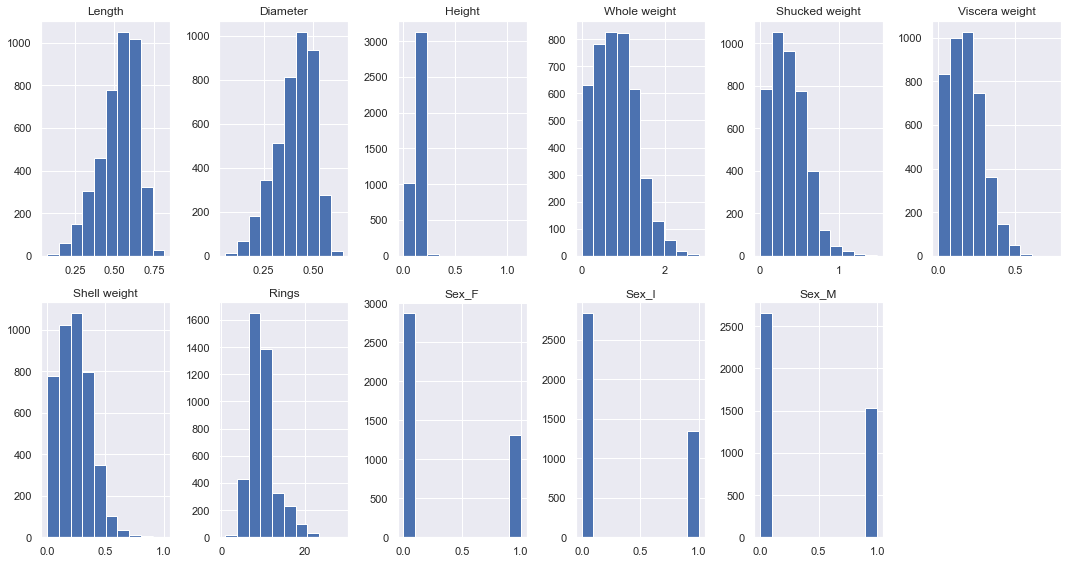

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 8))
axes = axes.flatten()
axes[-1].remove()
for col, ax in zip(df.columns, axes):
    ax.hist(df[col])
    ax.title.set_text(col)
plt.tight_layout();

The variables `Length` and `Diameter` are heavily left skewed, with central values of 0.6 for `Length` and 0.5 for `Diameter`. The dispersion, measured by the standard variations, is significant for both variables, i.e. the variables are well spread and the distributions almost describe a bell shape.

The variable `Height` seems centered around its mean of 0.14. The distribution is bell curve shaped and the dispersion is very small: the values are packed.

For the four `Weight` variables (`Whole weight`, `Schucked weight`, `Viscera weight` and `Shell weight`), we can observe the same tendencies. They are all heavily right skewed and have well spread values. 

The variable `Rings` is left skewed and seems to follow a form or normal disbribution centered around its mean of $\approx$ 10.

The variables `Sex_F`, `Sex_M`, `Sex_I` show that there are slightly more males than females or infants, but the distribution is still relatively homogeneous.

**Question 3**

*Generate a labeled scatterplot of the data. Describe interesting features trends. Does it agree with
the biologists’ hypothesis?*

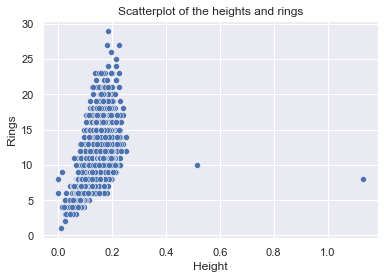

In [7]:
sns.scatterplot(data=df, x='Height', y='Rings').set_title('Scatterplot of the heights and rings');

It seems that the rings are an increasing function of the heights. The curve gets steeper as the value of the height increases. The spread of the rings values seems to increase as the heights increase.

Visually, there seems to be two outliers in the $X$-direction. We will explore this in a further question.

Nevertheless, generally, the trend does follow the biologists' hypothesis that the number of rings of abalones increases as their height increases. We will explore further if the nature of the relationship is indeed linear.

**Question 4**

*Fit a simple linear regression to the data predicting number of rings using height of the abalones.*

In [8]:
results = smf.ols('Rings ~ Height', data=df_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Rings   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     1208.
Date:                Wed, 25 Nov 2020   Prob (F-statistic):          7.04e-222
Time:                        11:54:23   Log-Likelihood:                -7118.0
No. Observations:                2923   AIC:                         1.424e+04
Df Residuals:                    2921   BIC:                         1.425e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2063      0.172     24.434      0.000       3.869       4.544
Height        41.0469      1.181     34.761      0.000      38.732      43.362
==============================================================================
Omnibus:                      783.366   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61721.708
Skew:                           0.209   Prob(JB):                         0.00
Kurtosis:                      25.508   Cond. No.                         23.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Question 5**

*Generate a labeled scatterplot that displays the data and the estimated regression function line.
Describe the line’s fit.*

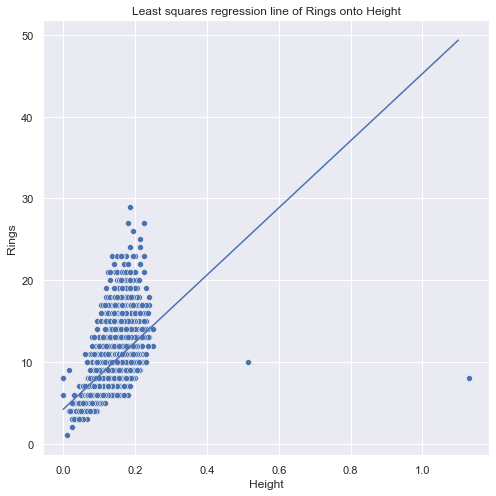

In [9]:
X = np.linspace(0.0, 1.1, 100)
a, b = results.params.Height, results.params.Intercept
Y = a * X + b
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df, x='Height', y='Rings').set_title('Least squares regression line of Rings onto Height')
plt.plot(X, Y);

It seems that a linear fit does not capture the essence of the relationship between `Rings` and `Height` accurately. In addition, the line seems affected by the presence of two influential points that are visually noticeable. We may apply transformations to the data to improve the fit of the model.

**Question 6**

*Do diagnostics to assess whether the model assumptions are met; if not, appropriately transform
height and/or number of rings and refit your model. Justify your decisions (and recheck your
diagnostics).*

We use the function imported at the beginning of the file to plot the diagostics plots.

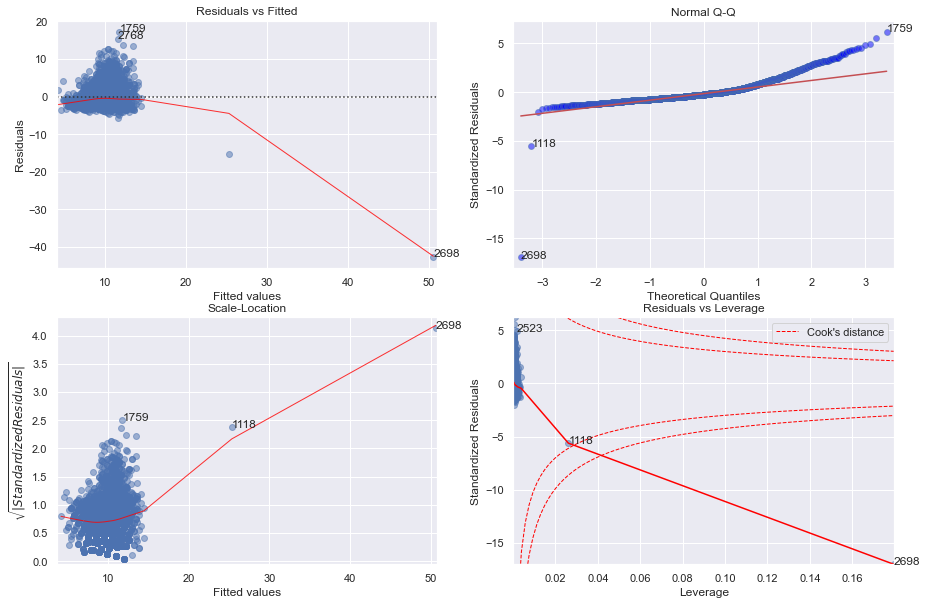

In [10]:
plot(results);

- **Residuals vs. Fitted plot**: This plot shows if residuals have non-linear patterns. An ideal plot would show random noise; there wouldn’t be any apparent patterns in the scatterplot and the red line would be horizontal. In our case the pattern does not look completely random and the red line is not flat, which could be an indicator that we are failing to capture some of the non-linear features of the model.

- **Normal Q-Q plot**: This plot shows whether the residuals are normally distributed. An ideal normal Q-Q plot would have all of the residuals lying on or very close to the red line. Looking at our graph, several points fall away from the red line, mainly on the right tail. The second postulate we made about the Gaussianty of errors is thus not verified for the points located on the right tail.

- **Scale - location plot**: This plot shows if residuals are spread equally along the ranges of predictors. This is how we can check the assumption of equal variance (homoscedasticity). In an ideal case we would see a horizontal line with equally (randomly) spread points.

- **Residuals vs. Leverage plot**: This plot helps us to find influential cases. We should bear in mind here that even though data may have extreme values, these may not be influential to determine a regression line. That means that the results would not be much different if we either included or excluded them from analysis. This plot shows that indeed the most extreme data point indexed is an outlier. We also appreciate a data point for which the Cook's distance is very close to 0.5, the removal of which will be shortly discussed.

We observed in the previous questions that the presence of two extreme values in the $X$-direction had a detrimental effect on the fit of the model. The calculation of Cook's distances on the dataset led us to successively remove these two points. For the sake of conciseness, we set the Cook's distance threshold for removing the measurements at $0.4$ in order to remove them in a single pass.

We create a new dataframe to fit a new regression line.

In [11]:
def remove_outliers(df, model_fit, threshold=0.4):
    influence = model_fit.get_influence()
    cook_distances = influence.summary_frame()['cooks_d']
    outliers = cook_distances > threshold
    outliers |= cook_distances.isna() # Handles the edge case when Cook's distance is infinity
    outliers_indexes = cook_distances[outliers].index
    df = df.drop(outliers_indexes)
    return df

In [12]:
df_train2 = remove_outliers(df_train, results);
results2 = smf.ols('Rings ~ Height', data=df_train2).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Rings   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     1746.
Date:                Wed, 25 Nov 2020   Prob (F-statistic):          1.39e-299
Time:                        11:54:28   Log-Likelihood:                -6934.7
No. Observations:                2921   AIC:                         1.387e+04
Df Residuals:                    2919   BIC:                         1.389e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6969      0.179     15.030      0.000       2.345       3.049
Height        52.0683      1.246     41.790      0.000      49.625      54.511
==============================================================================
Omnibus:                      933.677   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3002.491
Skew:                           1.618   Prob(JB):                         0.00
Kurtosis:                       6.768   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see, from the $r^2$ value, that the fit for our model has improved.

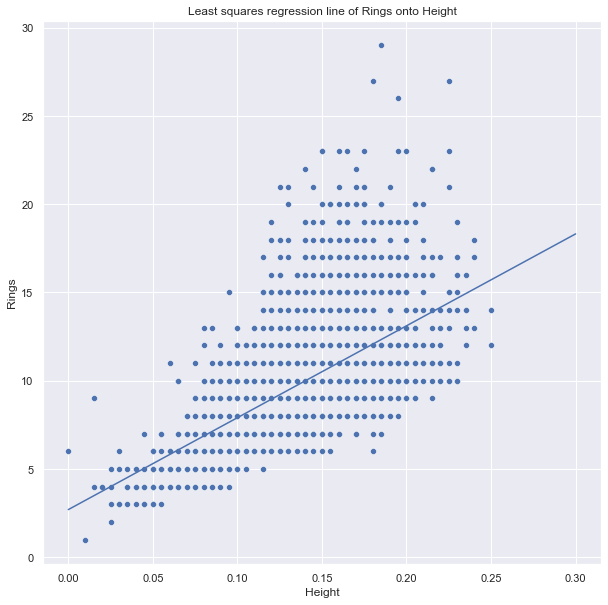

In [13]:
X = np.linspace(0.0, 0.3, 100)
a2, b2 = results2.params.Height, results2.params.Intercept
Y2 = a2 * X + b2
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_train2, x='Height', y='Rings').set_title('Least squares regression line of Rings onto Height')
plt.plot(X, Y2);

We display again the diagnostics plots after having removed the outliers.

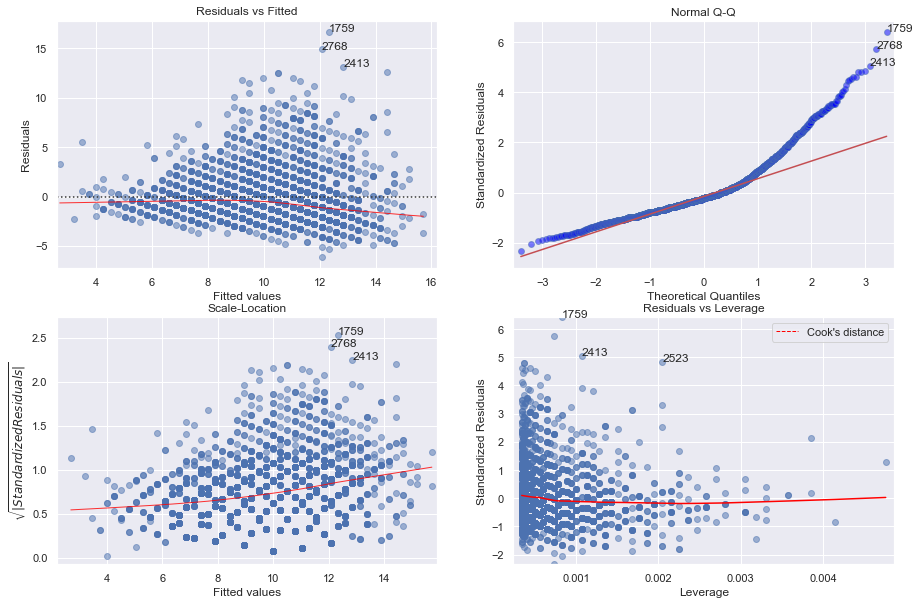

In [14]:
plot(results2);

- **Residuals vs. Fitted plot**: Now that the outliers have been removed we recover random noise with a non-linear pattern of residuals. The red line now appears flatter, as we would expect. 

- **Normal Q-Q plot**: Looking at our graph, several points still fall away from the red line, mainly on the right tail. The second postulate we made about the Gaussianity of errors is thus not verified for the points located on the right tail.

- **Scale - location plot**: Having removed the outliers the pattern of residuals is now more uniform, as randomly spread. The red line also appears flatter despite not being the perfectly horizontal line we would hope to get. 

- **Residuals vs. Leverage plot**: There does not appear to be any influential cases. There are no other outliers to remove.

We apply different transformations to the quantative response $Y$ in order to find a better fit for the data and improve the performance of the model.

The four transformations we apply to the variable `Rings` are:
- $\log(\text{Rings})$

- $\sqrt{\text{Rings}}$

- $\log({\sqrt{\text{Rings}}})$

- $\sqrt{\log(\text{Rings})}$

In [15]:
df_train3 = df_train2.copy()
df_train3['log_Rings'] = np.log2(df_train3['Rings'])
df_train3['sqrt_Rings'] = np.sqrt(df_train3['Rings'])
df_train3['log_sqrt_Rings'] = np.log(np.sqrt(df_train3['Rings']))
df_train3['sqrt_log_Rings'] = np.sqrt(np.log(df_train3['Rings']))

We perform the different regressions and plot the resulting lines and the value of $r^2$.

                y        r²
0           Rings  0.374336
2      sqrt_Rings  0.428909
1       log_Rings  0.471408
3  log_sqrt_Rings  0.471408
4  sqrt_log_Rings  0.473461




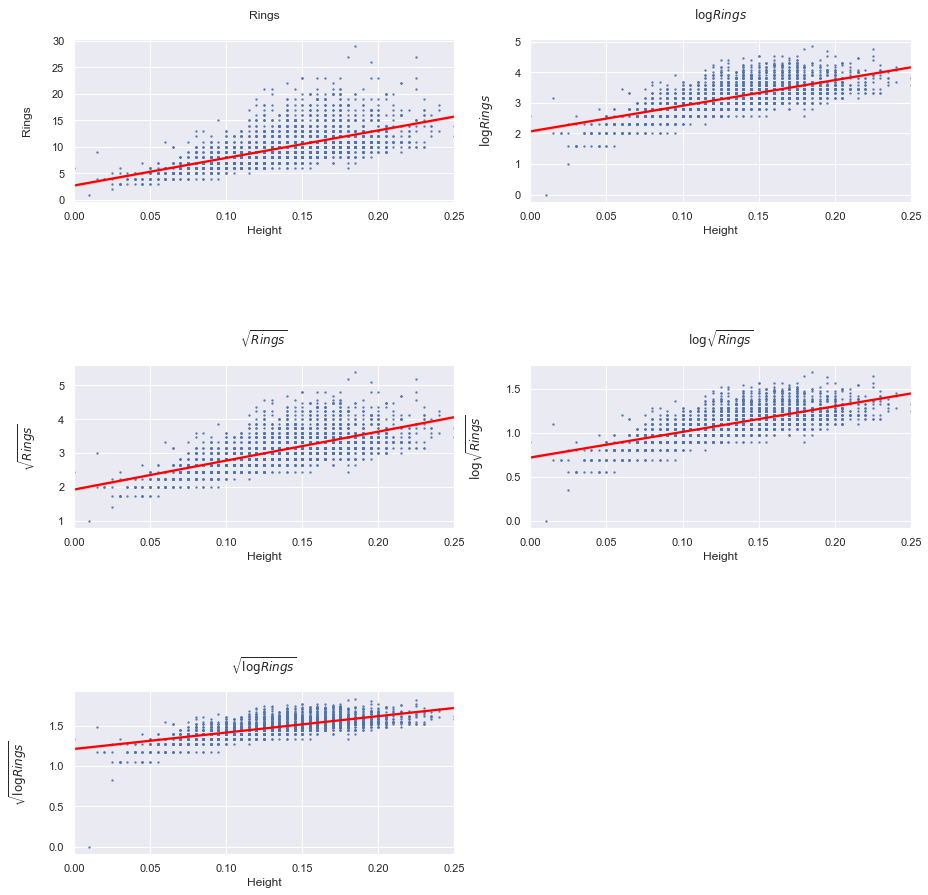

In [16]:
sns.set_theme(font_scale=1)

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=1)
axes = axes.flatten()
y_axes = ['Rings', 'log_Rings', 'sqrt_Rings', 'log_sqrt_Rings', 'sqrt_log_Rings']

r2_results = pd.DataFrame(columns=["y", "r²"])
r2_results["y"] = y_axes

VARS_TO_LATEX = {
  'log_Rings': '$\log{Rings}$',
  'sqrt_Rings': '$\sqrt{Rings}$',
  'log_sqrt_Rings': '$\log{\sqrt{Rings}}$',
  'sqrt_log_Rings': '$\sqrt{\log{Rings}}$'
}

for y, ax, k in zip(y_axes, axes, range(len(y_axes))):
    X = sm.add_constant(df_train3['Height'])
    result = sm.OLS(df_train3[y], X).fit()
    r2_results.iloc[k]["r²"] = result.rsquared
    sns.regplot(x='Height', y=y, data=df_train3, ax=ax, scatter_kws={'s': 2}, line_kws={"color": "red"})
    title = y_label = VARS_TO_LATEX[y] if y in VARS_TO_LATEX else y
    ax.set_title(title, pad=20)
    ax.set_ylabel(y_label, labelpad=20)

axes[-1].remove()

r2_results.sort_values(by=['r²'], inplace=True)
print(r2_results.head())
print('\n')

sns.set_theme(font_scale=1);

Those results show that the transformation of $Y$ into $\sqrt{\log{Y}}$ is the model which succeeds the most in representing the relationship between `Rings` and `Height`. The $r^2$ is the highest among all of the transformations we have applied, and it can also be seen graphically with tighter points around the $Y$ line.

In [17]:
results3 = smf.ols('sqrt_log_Rings ~ Height', data=df_train3).fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_log_Rings   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     2625.
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:54:32   Log-Likelihood:                 3137.5
No. Observations:                2921   AIC:                            -6271.
Df Residuals:                    2919   BIC:                            -6259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2114      0.006    212.274      0.000       1.200       1.223
Height         2.0301      0.040     51.232      0.000       1.952       2.108
==============================================================================
Omnibus:                      929.317   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35933.787
Skew:                          -0.808   Prob(JB):                         0.00
Kurtosis:                      20.107   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

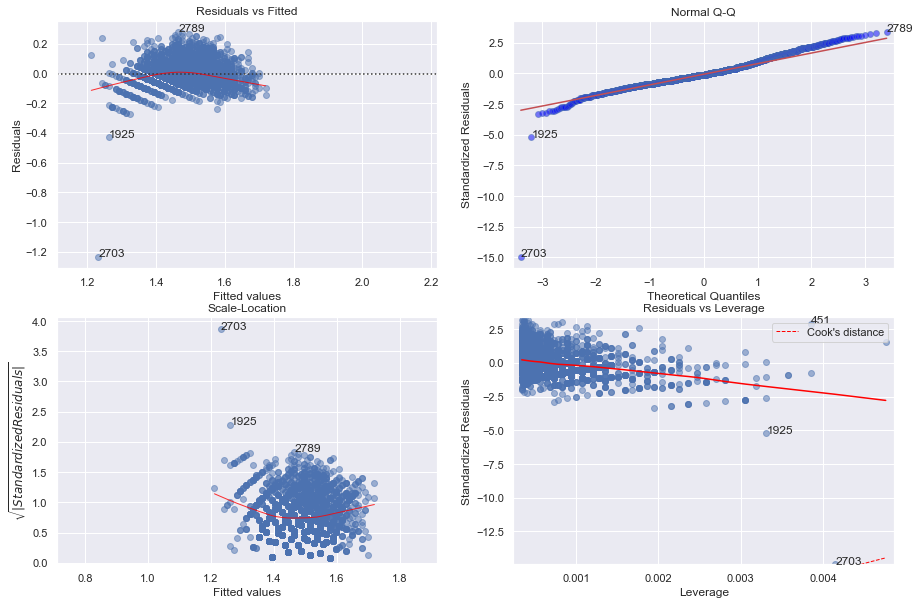

In [18]:
plot(results3)

From the Residuals vs Leverage graph, we can visually detect the presence of a potential outlier. Let us remove all outliers present in this new model and fit it again.

In [19]:
df_train4 = remove_outliers(df_train3, results3);
results4 = smf.ols('sqrt_log_Rings ~ Height', data=df_train4).fit()
results4.summary();

We can see, from the $r^2$ value, that the fit for our model has improved.

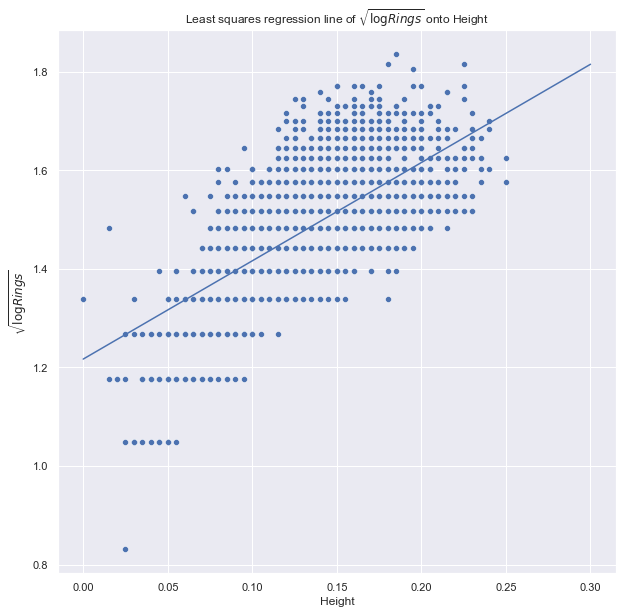

In [20]:
X = np.linspace(0.0, 0.3, 100)
a4, b4 = results4.params.Height, results4.params.Intercept
Y4 = a4 * X + b4
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=df_train4, x='Height', y='sqrt_log_Rings').set_title('Least squares regression line of $\sqrt{\log{Rings}}$ onto Height')
plt.ylabel('$\sqrt{\log{Rings}}$')
plt.plot(X, Y4);

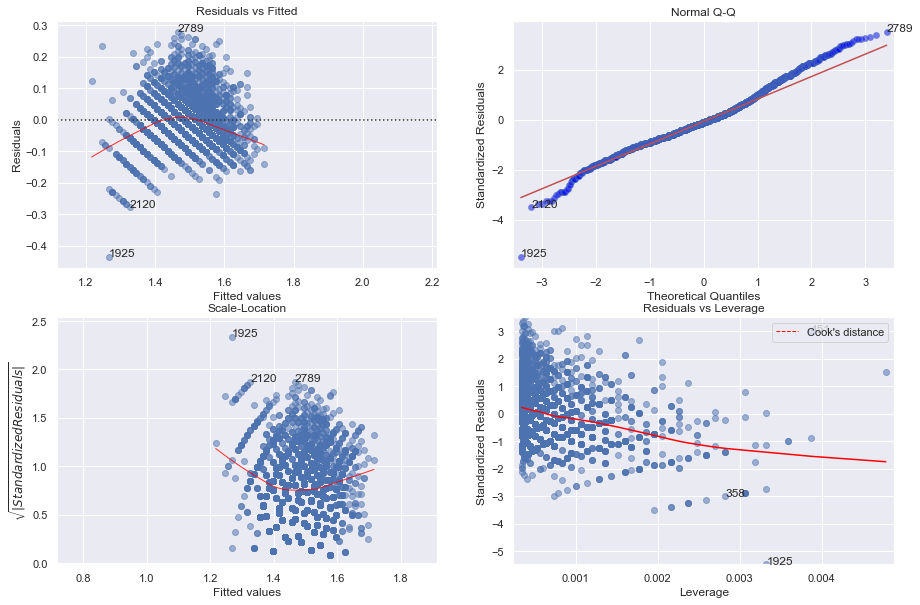

In [21]:
plot(results4)

**Question 7**

*Interpret your final parameter estimates in context. Provide 95% confidence intervals for $\beta_0$ and
$\beta_1$. Interpret in context of the problem.*

In [22]:
print('Regression results:')
print(results4.params)
print('\n')
confidence_intervals = results4.conf_int(alpha=0.05)
print('Confidence intervals:')
print(confidence_intervals)
std_err = results4.mse_model
print('\n')
print('Standard error:')
print(std_err)

Regression results:
Intercept    1.216893
Height       1.993512
dtype: float64


Confidence intervals:
                  0         1
Intercept  1.206115  1.227671
Height     1.918685  2.068339


Standard error:
17.2385462959786


The least squares coefficient estimates we obtain from the model are:

- $\hat\beta_0$ (Intercept): 1.217
- $\hat\beta_1$ (`Height`): 1.994

There is indeed a positive relationship between the transformation of `Rings` we chose and `Height`, as the value of $\hat\beta_1$ is positive.

The final relationship we have is:

$\hat{\sqrt{\log{\text{Rings}}}} \approx 1.994 \times \text{Height} + 1.127$

The 95% confidence interval for $\beta_0$ is $[1.206, 1.228]$ and the 95% confidence interval is $[1.919, 2.068]$. With a 95% probability, the ranges will contain the true unknown values of the parameters $\beta_0$ and $\beta_1$.

**Question 8**

*Is there a statistically significant relationship between the height and the number of rings (and
hence, the age) of abalones?*

As seen in the introduction, to test if there is a statistically significant relationship between the height and the number of rings, we will carry out a test. The hypotheses are:
- The __null hypothesis__ $H_0$ : $\beta_1 = 0$
- The __alternative hypothesis__ $H_1$ : $\beta_1 \neq 0$

In [23]:
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_log_Rings   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     2729.
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:54:38   Log-Likelihood:                 3251.8
No. Observations:                2920   AIC:                            -6500.
Df Residuals:                    2918   BIC:                            -6488.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2169      0.005    221.375      0.000       1.206       1.228
Height         1.9935      0.038     52.238      0.000       1.919       2.068
==============================================================================
Omnibus:                       96.725   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.837
Skew:                           0.341   Prob(JB):                     3.19e-30
Kurtosis:                       3.807   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let us know look at the p-value associated to the coefficient $\beta_1$, namely, the one appearing for `Height` in the summary.

The p-value for the independent variable tests the $H_0$, i.e. that the independent variable has no relationship with the dependent variable.

The p-value we observe is less than the significance level of $0.05$. Hence, we can infer that there is an association between the predictor `Height` and the response. We reject the null hypothesis, i.e. we declare that a relationship exists between $X$ and $Y$.

Therefore, we can conclude that the biologists' hypothesis is right: a simple linear model is somewhat appropriate to describe the relationship between the height of the abalones and their ages, if some transformation is applied. However, there is a caveat: the $r^2$ value of $0.483$ indicates a non optimal performance of the model.

### Part II Multiple linear regression, ANOVA, ANCOVA

**Question 9**

*Consider now all variables. Look at the scatterplot of the data (seaborn:pairplot).*

*Look for correlations betwwen predictors.* 

*Select some additional variables to add to the simple linear model of Part II in order to better predict number of rings.* 

*Justify your choices (keep in mind that we want a practical method to predict number of rings).*

*Perform a multiple linear regression.*

*Check the validity of the model. If validity conditions are not met, transform some variables, add/delete some variables and recheck until you find an acceptable model.*

In [24]:
df = load_data()
df_train = df.loc[indexes].reset_index(drop=True) # We reindex the dataframes in order to prevent errors laterfa
df_test = df.loc[~(df.index.isin(indexes))].reset_index(drop=True)
df['Sex'] = pd.Categorical(df['Sex'])

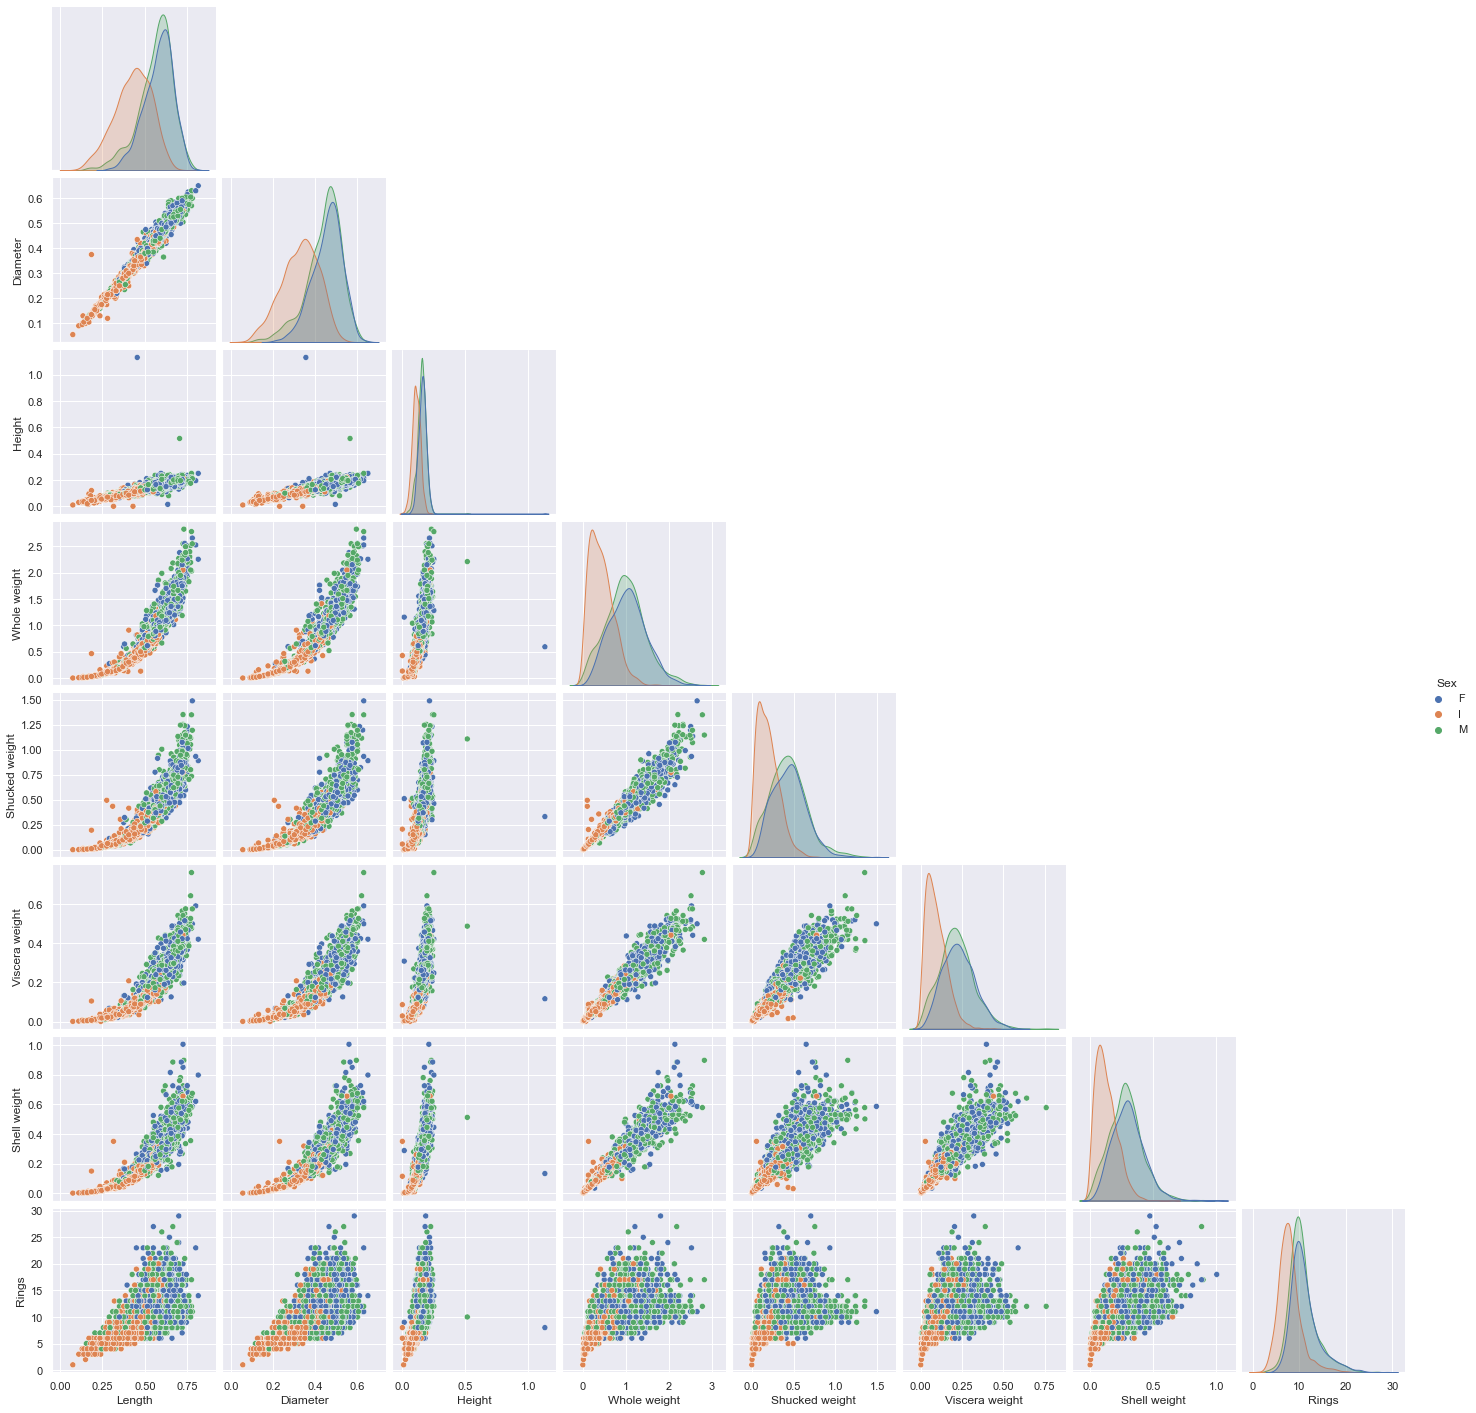

In [25]:
sns.pairplot(df, hue='Sex', corner=True)
plt.show()

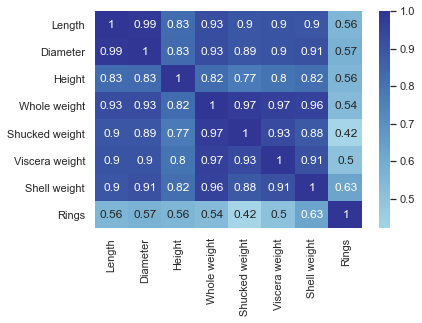

In [26]:
corr = df.corr()
sns.heatmap(corr, center=0, annot=True, cmap='RdYlBu');

Looking both at the pairplots and the correlation matrix, we can observe the following:

- Obvious correlation between the  four weight predictors: `Whole weight` is the addition of the others
- Nearly perfect positive correlation between `Length` and `Diameter`
- Similar behavior between males and females with respect to other predictors

The analysis of the correlation coefficients lead us to think that `Diameter` could be a good predictor of `Rings`. Among all the features, `Shell weight` has the highest correlation coefficient with `Rings`. We will try to fit a regression model using these variables.

In [27]:
df_train.columns = df_train.columns.str.replace(' ', '_')
df_train.columns = df_train.columns.str.strip().str.lower()
df_train['sqrt_log_rings'] = np.sqrt(np.log(df_train['rings']))
multi_reg_model1 = smf.ols('sqrt_log_rings ~ height + shell_weight + diameter', data=df_train).fit()
multi_reg_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_log_rings   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     905.2
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:55:02   Log-Likelihood:                 3164.2
No. Observations:                2923   AIC:                            -6320.
Df Residuals:                    2919   BIC:                            -6297.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.2175      0.010    127.406      0.000       1.199       1.236
height           0.3653      0.061      5.973      0.000       0.245       0.485
shell_weight     0.1479      0.026      5.784      0.000       0.098       0.198
diameter         0.4666      0.038     12.332      0.000       0.392       0.541
==============================================================================
Omnibus:                      968.149   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42941.045
Skew:                          -0.831   Prob(JB):                         0.00
Kurtosis:                      21.703   Cond. No.                         46.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

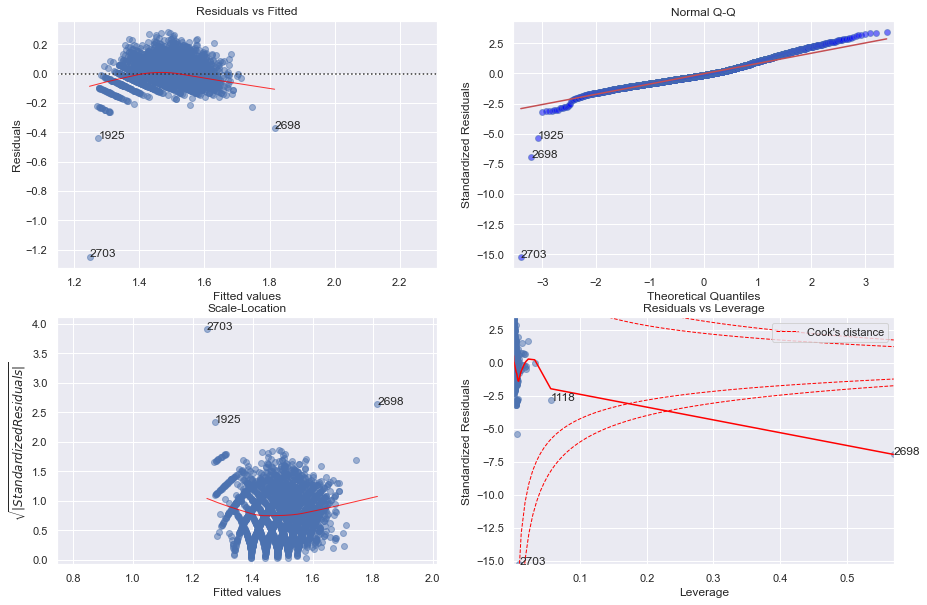

In [28]:
plot(multi_reg_model1)

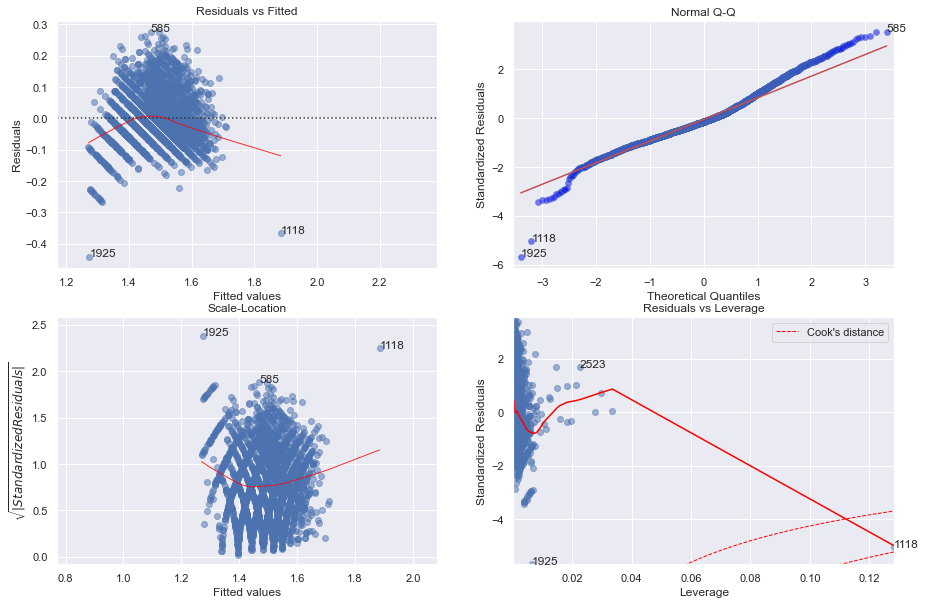

In [29]:
df_train = remove_outliers(df_train, multi_reg_model1)
multi_reg_model2 = smf.ols('sqrt_log_rings ~ height + shell_weight + diameter', data=df_train).fit()
plot(multi_reg_model2)

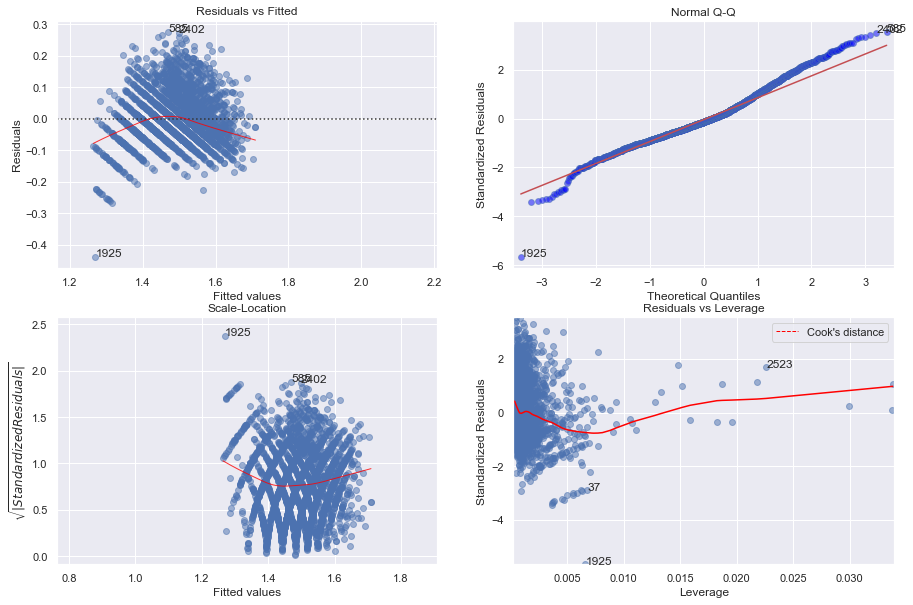

In [30]:
df_train = remove_outliers(df_train, multi_reg_model2)
multi_reg_model3 = smf.ols('sqrt_log_rings ~ height + shell_weight + diameter', data=df_train).fit()
plot(multi_reg_model3)

In [31]:
multi_reg_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_log_rings   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     996.0
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:55:29   Log-Likelihood:                 3317.8
No. Observations:                2920   AIC:                            -6628.
Df Residuals:                    2916   BIC:                            -6604.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.2166      0.009    131.358      0.000       1.198       1.235
height           0.9840      0.095     10.398      0.000       0.798       1.170
shell_weight     0.1112      0.025      4.377      0.000       0.061       0.161
diameter         0.2804      0.040      7.062      0.000       0.203       0.358
==============================================================================
Omnibus:                      121.055   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.658
Skew:                           0.411   Prob(JB):                     1.07e-36
Kurtosis:                       3.827   Cond. No.                         75.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
df_train['height_squared'] = df_train['height'] ** 2
multi_reg_model4 = smf.ols('sqrt_log_rings ~ height + height_squared + shell_weight + diameter', data=df_train).fit()
multi_reg_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_log_rings   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     928.5
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:55:29   Log-Likelihood:                 3487.4
No. Observations:                2920   AIC:                            -6965.
Df Residuals:                    2915   BIC:                            -6935.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.0536      0.012     85.918      0.000       1.030       1.078
height             5.5419      0.257     21.598      0.000       5.039       6.045
height_squared   -16.3188      0.861    -18.948      0.000     -18.007     -14.630
shell_weight       0.4189      0.029     14.462      0.000       0.362       0.476
diameter          -0.2216      0.046     -4.828      0.000      -0.312      -0.132
==============================================================================
Omnibus:                      136.651   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.267
Skew:                           0.493   Prob(JB):                     4.77e-37
Kurtosis:                       3.635   Cond. No.                         736.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

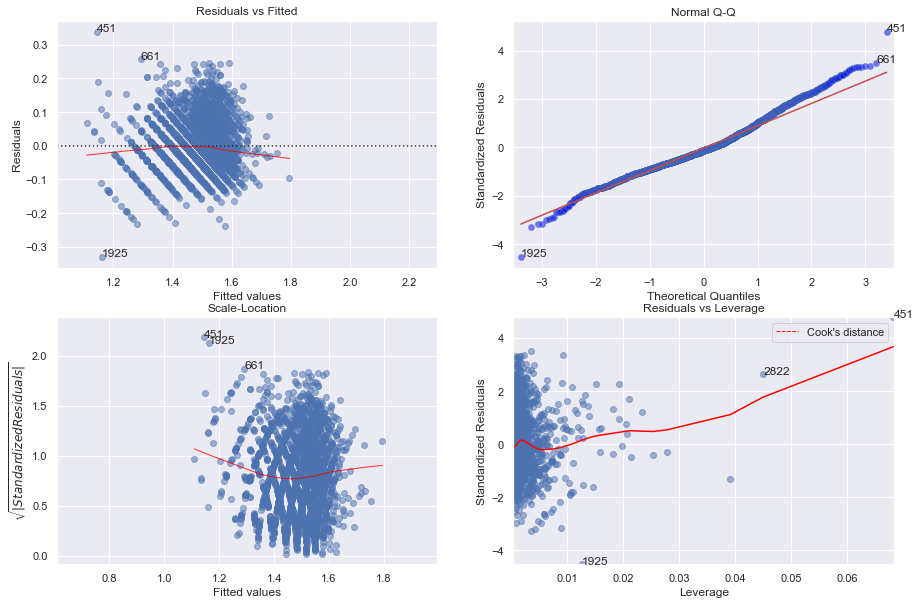

In [33]:
plot(multi_reg_model4)

We see improvements regarding the statistical assumptions made about the error terms when we add a polynomial transformation of degree 2 of the predictor `height`. Looking at the adjusted $R^2$, it seems that it improves the overall quality of fit of the model.

**Question 10**

*Perform t-tests to check which variables have a significant impact on number of rings.*

In [34]:
multi_reg_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_log_rings   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     928.5
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:55:36   Log-Likelihood:                 3487.4
No. Observations:                2920   AIC:                            -6965.
Df Residuals:                    2915   BIC:                            -6935.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.0536      0.012     85.918      0.000       1.030       1.078
height             5.5419      0.257     21.598      0.000       5.039       6.045
height_squared   -16.3188      0.861    -18.948      0.000     -18.007     -14.630
shell_weight       0.4189      0.029     14.462      0.000       0.362       0.476
diameter          -0.2216      0.046     -4.828      0.000      -0.312      -0.132
==============================================================================
Omnibus:                      136.651   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.267
Skew:                           0.493   Prob(JB):                     4.77e-37
Kurtosis:                       3.635   Cond. No.                         736.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We recall that for each one the coefficient, the t-test null hpothesis is $H_0$ : $\beta_{j} = 0$, i.e. the impact of the variable $x_{j}$ on the response `Rings` is not statistically significant.

Assuming we choose a standard significance level of 5%, we can reject the null hypotheses for all the predictors, as the p-values are lower than 0.05. Thus, we conclude that there a significant linear relationship between the four predictors we previously chose and the number of rings.

**Question 11**

*Perform an ANOVA test to decide between the simple linear model and the multiple linear model.*

Looking at the pair plots, we see that `Height` and `Diameter` are highly correlated. Therefore, we decide to test our model including an interaction term to assess whether this has an impact.  

In [35]:
multi_reg_model5 = smf.ols("sqrt_log_rings ~ height + height_squared + shell_weight + diameter + height:diameter", data=df_train).fit()
multi_reg_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_log_rings   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     843.7
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:55:36   Log-Likelihood:                 3594.8
No. Observations:                2920   AIC:                            -7178.
Df Residuals:                    2914   BIC:                            -7142.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9337      0.014     65.310      0.000       0.906       0.962
height              3.6205      0.279     12.981      0.000       3.074       4.167
height_squared      4.8605      1.645      2.955      0.003       1.635       8.086
shell_weight        0.5281      0.029     18.295      0.000       0.472       0.585
diameter            1.1416      0.102     11.243      0.000       0.943       1.341
height:diameter   -10.5713      0.709    -14.915      0.000     -11.961      -9.181
==============================================================================
Omnibus:                      129.011   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.981
Skew:                           0.492   Prob(JB):                     9.95e-34
Kurtosis:                       3.529   Cond. No.                     1.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
sm.stats.anova_lm(multi_reg_model5, typ=2)

,sum_sq,df,F,PR(>F)
height,2.510262,1.0,501.908869,1.066264e-102
height_squared,0.043667,1.0,8.730813,3.153837e-03
shell_weight,1.673928,1.0,334.689903,7.315457e-71
diameter,0.125457,1.0,25.084154,5.815320e-07
height:diameter,1.112553,1.0,222.447024,1.561356e-48
Residual,14.574165,2914.0,NaN,NaN


Performing the ANOVA type 2 test, interactions between height and diameter have a significant impact on the model and should be included.

We now perform an anova test to compare our simple model with our more complicated one and accept or reject our hypothesis. 

In [37]:
sm.stats.anova_lm(results4, multi_reg_model5)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2918.0,18.433547,0.0,NaN,NaN,NaN
1,2914.0,14.574165,4.0,3.859382,192.913929,6.839875e-147


We recall that the null hypothesis we are testing is that the simple regression model is enough to predict the number of rings.

Here, because the p-value is below the standard significance level of 5%, we reject the null hypothesis and conclude that the multiple linear regression model is better than the simple one.

**Question 12**

*We want to determine whether the covariate sex has an impact on the number of rings? To this end,
add the variable sex to the previous multiple linear model (if you did not already) and perform
and ANCOVA analysis of the dataset.*

In [38]:
df = load_data()
df = pd.get_dummies(df, columns=['Sex'])
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.strip().str.lower()
df['sqrt_log_rings'] = np.sqrt(np.log(df['rings']))
df['height_squared'] = df['height']**2
df_train = df.loc[indexes].reset_index(drop=True) # We reindex the dataframes in order to prevent errors laterfa
df_test = df.loc[~(df.index.isin(indexes))].reset_index(drop=True)

First we add the `sex_i` (infant) variable to the model.

In [39]:
multi_reg_model7 = smf.ols('sqrt_log_rings ~ height + height_squared + shell_weight + diameter + height:diameter + sex_i', data=df_train).fit()
multi_reg_model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_log_rings   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     705.0
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:55:37   Log-Likelihood:                 3513.0
No. Observations:                2923   AIC:                            -7012.
Df Residuals:                    2916   BIC:                            -6970.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9637      0.015     65.255      0.000       0.935       0.993
height              4.5146      0.171     26.343      0.000       4.179       4.851
height_squared     -1.2422      0.117    -10.632      0.000      -1.471      -1.013
shell_weight        0.4949      0.029     17.113      0.000       0.438       0.552
diameter            0.7813      0.045     17.216      0.000       0.692       0.870
height:diameter    -8.3140      0.346    -24.050      0.000      -8.992      -7.636
sex_i              -0.0264      0.004     -7.496      0.000      -0.033      -0.020
==============================================================================
Omnibus:                      728.447   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22033.148
Skew:                          -0.529   Prob(JB):                         0.00
Kurtosis:                      16.409   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

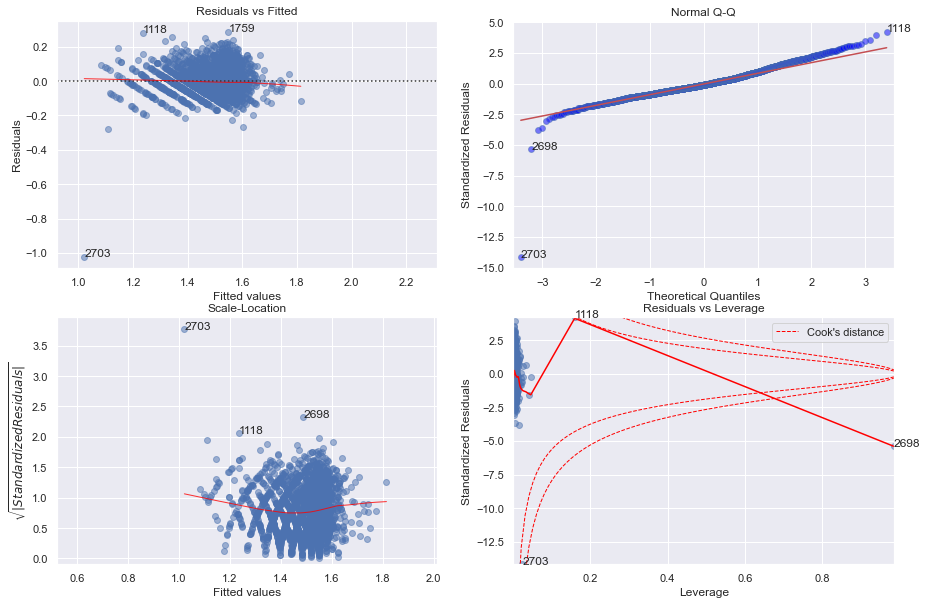

In [40]:
plot(multi_reg_model7)

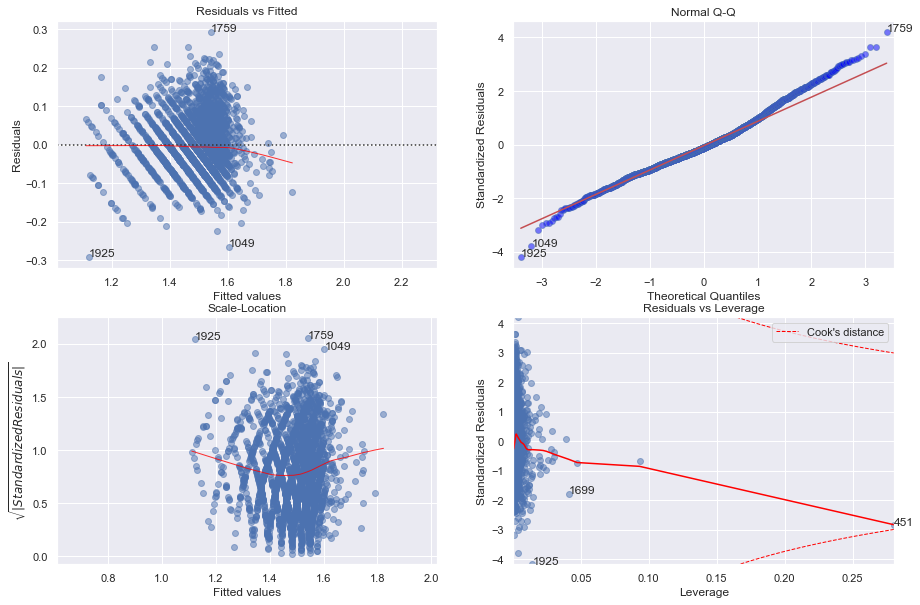

In [41]:
df_train = remove_outliers(df_train, multi_reg_model7)
multi_reg_model8 = smf.ols('sqrt_log_rings ~ height + height_squared + shell_weight + diameter + height:diameter + sex_i', data=df_train).fit()
plot(multi_reg_model8)

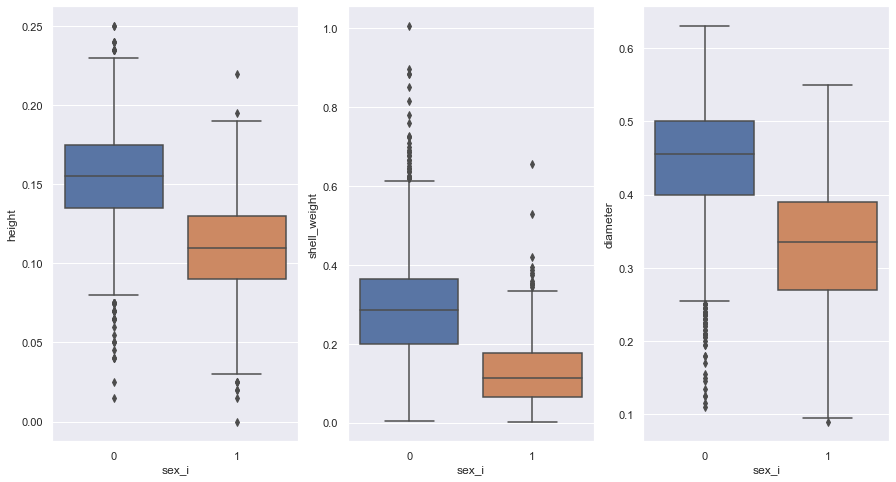

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes = axes.flatten()
for var, ax in zip(['height', 'shell_weight', 'diameter'], axes):
    sns.boxplot(y=var,x='sex_i',data=df_train, ax=ax)

Looking at the boxplots, we see that the `sex_i` variable seems correlated to the `height`, `shell_weight` and `diameter`. Therefore, we decide to test our model including interaction terms to assess whether they have an impact.

In [43]:
multi_reg_model9 = smf.ols('sqrt_log_rings ~ height + height_squared + shell_weight + diameter + height:diameter + sex_i + sex_i:height + sex_i:shell_weight + sex_i:diameter', data=df_train).fit()
multi_reg_model9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_log_rings   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     496.9
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:55:56   Log-Likelihood:                 3647.1
No. Observations:                2920   AIC:                            -7274.
Df Residuals:                    2910   BIC:                            -7214.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.0685      0.025     43.476      0.000       1.020       1.117
height                 2.8589      0.335      8.533      0.000       2.202       3.516
height_squared         5.2042      1.719      3.027      0.002       1.833       8.575
shell_weight           0.5041      0.029     17.284      0.000       0.447       0.561
diameter               0.9046      0.117      7.723      0.000       0.675       1.134
height:diameter       -9.2637      0.765    -12.114      0.000     -10.763      -7.764
sex_i                 -0.1040      0.023     -4.568      0.000      -0.149      -0.059
sex_i:height           0.1447      0.228      0.636      0.525      -0.302       0.591
sex_i:shell_weight     0.0856      0.076      1.131      0.258      -0.063       0.234
sex_i:diameter         0.1198      0.095      1.257      0.209      -0.067       0.307
==============================================================================
Omnibus:                      104.027   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.949
Skew:                           0.400   Prob(JB):                     6.05e-29
Kurtosis:                       3.655   Cond. No.                     1.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
sm.stats.anova_lm(multi_reg_model9, typ=2)

,sum_sq,df,F,PR(>F)
height,1.005558,1.0,208.094639,1.291480e-45
height_squared,0.044283,1.0,9.164078,2.489755e-03
shell_weight,1.555719,1.0,321.947589,2.307740e-68
diameter,0.183688,1.0,38.013251,7.997981e-10
height:diameter,0.709163,1.0,146.757417,5.444514e-33
sex_i,0.331622,1.0,68.627317,1.792178e-16
sex_i:height,0.001953,1.0,0.404113,5.250228e-01
sex_i:shell_weight,0.006187,1.0,1.280268,2.579424e-01
sex_i:diameter,0.007640,1.0,1.581024,2.087141e-01
Residual,14.061741,2910.0,NaN,NaN


It appears the interaction between `sex_i`and `height` returns the highest p-value. We decide to disregard it and test our model without that interaction.

In [52]:
multi_reg_model10 = smf.ols('sqrt_log_rings ~ height + height_squared + shell_weight + diameter + height:diameter + sex_i + sex_i:shell_weight + sex_i:diameter', data=df_train).fit()
multi_reg_model10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_log_rings   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     559.1
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:57:06   Log-Likelihood:                 3646.9
No. Observations:                2920   AIC:                            -7276.
Df Residuals:                    2911   BIC:                            -7222.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.0647      0.024     44.698      0.000       1.018       1.111
height                 2.9677      0.288     10.304      0.000       2.403       3.532
height_squared         4.8499      1.626      2.983      0.003       1.661       8.038
shell_weight           0.5033      0.029     17.274      0.000       0.446       0.560
diameter               0.8862      0.114      7.808      0.000       0.664       1.109
height:diameter       -9.2033      0.759    -12.130      0.000     -10.691      -7.716
sex_i                 -0.0995      0.022     -4.596      0.000      -0.142      -0.057
sex_i:shell_weight     0.1015      0.071      1.422      0.155      -0.038       0.242
sex_i:diameter         0.1490      0.083      1.787      0.074      -0.014       0.313
==============================================================================
Omnibus:                      106.108   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.624
Skew:                           0.405   Prob(JB):                     1.59e-29
Kurtosis:                       3.658   Cond. No.                     1.61e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
sm.stats.anova_lm(multi_reg_model10, typ=2)

,sum_sq,df,F,PR(>F)
height,1.005558,1.0,208.137246,1.264448e-45
height_squared,0.042975,1.0,8.895356,2.882693e-03
shell_weight,1.562784,1.0,323.475723,1.154492e-68
diameter,0.209860,1.0,43.438266,5.174807e-11
height:diameter,0.710905,1.0,147.148054,4.512380e-33
sex_i,0.331622,1.0,68.641368,1.779500e-16
sex_i:shell_weight,0.009769,1.0,2.021961,1.551460e-01
sex_i:diameter,0.015428,1.0,3.193346,7.404256e-02
Residual,14.063694,2911.0,NaN,NaN


After having removed the `sex_i:height` term we see that the interaction term between `sex_i` and `shell_weight` returns a high p-value as well. We also infer that we should not add that term to our model as the interaction would have an insignificant impact.


In [62]:
multi_reg_model11 = smf.ols('sqrt_log_rings ~ height + height_squared + shell_weight + diameter + height:diameter + sex_i + sex_i:diameter', data=df_train).fit()
multi_reg_model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_log_rings   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     638.4
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:15:55   Log-Likelihood:                 3645.9
No. Observations:                2920   AIC:                            -7276.
Df Residuals:                    2912   BIC:                            -7228.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.0747      0.023     47.202      0.000       1.030       1.119
height              2.9372      0.287     10.224      0.000       2.374       3.500
height_squared      4.7116      1.623      2.902      0.004       1.528       7.895
shell_weight        0.5121      0.028     17.982      0.000       0.456       0.568
diameter            0.8492      0.111      7.685      0.000       0.633       1.066
height:diameter    -9.0326      0.749    -12.055      0.000     -10.502      -7.563
sex_i              -0.1203      0.016     -7.528      0.000      -0.152      -0.089
sex_i:diameter      0.2511      0.042      5.915      0.000       0.168       0.334
==============================================================================
Omnibus:                      108.173   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.828
Skew:                           0.412   Prob(JB):                     5.28e-30
Kurtosis:                       3.656   Cond. No.                     1.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
sm.stats.anova_lm(multi_reg_model11, typ=2)

,sum_sq,df,F,PR(>F)
height,1.031156,1.0,213.360946,1.093103e-46
height_squared,0.040705,1.0,8.422417,3.734056e-03
shell_weight,1.562784,1.0,323.362240,1.211901e-68
diameter,0.152317,1.0,31.516479,2.163738e-08
height:diameter,0.702363,1.0,145.329015,1.078425e-32
sex_i,0.331622,1.0,68.617287,1.800607e-16
sex_i:diameter,0.169081,1.0,34.985167,3.709116e-09
Residual,14.073463,2912.0,NaN,NaN


Finally, the remaining `sex_i` and `diameter` interaction term appears to have an impact therefore we decide to keep it in our model.

Therefore, we have the following model:

$\hat{\sqrt{\log \text{Rings}}} = 1.07 + 2.94 \text{ Height}+ 4.71 \text{ Height}^2 + 0.51 \text{ Shell weight}+ 0.85 \text{ Diameter} - 9.03 \text{ Height:Diameter} - 0.12 \text{ Sex_i} + 0.25 \text{ Sex_i:Diameter}$

The inclusion of the interaction terms and the sex_i variable allowed for a more complete model to predict rings. This is also confirmed by the new adjusted $R^2$ value that is now of $0.604$, as opposed to our adjusted $R^2$ of $0.560$ obtained in question 9.

<AxesSubplot:xlabel='sex_i', ylabel='rings'>

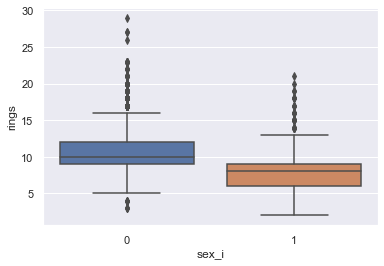

In [60]:
sns.boxplot(y='rings',x='sex_i',data=df_train)

The boxplot shows an effect of the categorical variable `sex_i` (i.e, Infant/Non-infant) on the number of rings.

In [64]:
ancova(data=df_train, dv='sqrt_log_rings', covar=['height', 'height_squared', 'shell_weight', 'diameter'], between='sex_i')

,Source,SS,DF,F,p-unc,np2
0,sex_i,0.312824,1,59.293261,1.847626e-14,0.019942
1,height,2.336803,1,442.922446,1.183792e-91,0.131943
2,height_squared,1.830778,1,347.009513,2.898894e-73,0.106412
3,shell_weight,1.015342,1,192.450041,2.011328e-42,0.061952
4,diameter,0.152317,1,28.870409,8.348858e-08,0.009810
5,Residual,15.373894,2914,NaN,NaN,NaN


We decided not to keep differentiating between males and females and only keep the categorical variable `sex_i` which differentiates between adults and infants, as it seemed to be the most determinant factor.

From the ANCOVA table, it can be seen that the p-value for `sex_i` is less than 0.05. Thus, we can reject the null hypothesis that for each sex category the average for the response variable (i.e, `rings`) is equal, taking into account the other numerical variables. This agrees with what we expected.